In [11]:
%config InlineBackend.figure_format = 'retina'
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

from termcolor import colored
import platform
HOSTNAME = platform.node().split('.')[0]

import os
HOME = os.environ['HOME']

try:
    import ipynbname
except ImportError:
    !pip install ipynbname > /dev/null
import ipynbname
FILEPATH = str(ipynbname.path()).replace(HOME+'/','')

import pwd
USER=pwd.getpwuid(os.geteuid())[0]

from datetime import date
TODAY=date.today()

import torch
TORCH_VERSION = torch.__version__

color = 'green'
print('日付:',colored(f'{TODAY}', color=color, attrs=['bold']))
print('HOSTNAME:',colored(f'{HOSTNAME}', color=color, attrs=['bold']))
print('ユーザ名:',colored(f'{USER}', color=color, attrs=['bold']))
print('HOME:',colored(f'{HOME}', color=color,attrs=['bold']))
print('ファイル名:',colored(f'{FILEPATH}', color=color, attrs=['bold']))
print('torch.__version__:',colored(f'{TORCH_VERSION}', color=color, attrs=['bold']))

日付: 2022-06-23
HOSTNAME: Sinope
ユーザ名: _asakawa
HOME: /Users/_asakawa
ファイル名: study/2022komazawa-deep-learning_komazawa-deep-learning.github.io/2022notebooks/2022_0616muller_lyer_demo.ipynb
torch.__version__: 1.11.0


In [12]:
%matplotlib inline
import typing
import os
import random
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import japanize_matplotlib

import PIL
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [10]:
float_COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
                [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

_c = []
for col in float_COLORS:
    _c.append(tuple([int(c * 256) for c in col]))
int_COLORS = _c * 100
float_COLORS = float_COLORS * 100


In [22]:
DEFAULT_CANVAS_WIDTH = 512  #224
DEFAULT_CANVAS_HEIGHT = 512 #224
DEFAULT_LINE_LENGTH = int((DEFAULT_CANVAS_WIDTH >> 2) * 2)
DEFAULT_LINE_WIDTH = 3
DEFALUT_X0 = DEFAULT_CANVAS_WIDTH >> 3
DEFALUT_Y0 = DEFAULT_CANVAS_HEIGHT >> 1
DEFAULT_FIN_LENGTH = int((DEFAULT_LINE_LENGTH >> 2))

def rad2deg(rad:float)->float:
    """1度が180/pi ラジアンなのでその変換"""
    return 180 * rad / np.pi


def deg2rad(deg:float)->float:
    """度をラジアンに変換する"""
    return np.pi * deg / 180


def make_a_canvas(width:int=DEFAULT_CANVAS_WIDTH,
                  height:int=DEFAULT_CANVAS_HEIGHT,
                  color:tuple=(255,255,255), # 真っ白な (255,255,255) 画像
                  verbose:bool=False,
                 )->PIL.Image.Image:
    '''刺激を描くためのキャンバスを作成して返す'''
    print(f'画像サイズ width:{width}, height:{height}') if verbose else None
    img = Image.new(mode='RGB', size=(width, height), color=color)  
    draw = ImageDraw.Draw(img)  # draw オブジェクト ある種のキャンバスを生成
    
    return img, draw
    
def set_new_canvas(width:int=DEFAULT_CANVAS_WIDTH,
                   height:int=DEFAULT_CANVAS_HEIGHT):
    canvas, draw = make_a_canvas(width=width, height=height)
    
    return canvas, draw


def draw_a_muller_lyer(draw:PIL.ImageDraw.ImageDraw=None,
                      x0:int=DEFALUT_X0,                # 主線の開始座標 x
                      y0:int=DEFALUT_Y0,                # 主線の開始座標 y
                      fin_length=DEFAULT_FIN_LENGTH,    # 矢羽の長さ
                      theta:float=np.pi / 4,            # 矢羽の主線に対する角度，単位ラジアン
                      _length:int=DEFAULT_LINE_LENGTH,  # 主線の長さ
                      _width:int=DEFAULT_LINE_WIDTH,    # 主線の幅
                      fg_color:tuple=(0,0,0),           # 色 3 原色
                      verbose=False,                    # 情報の表示
                     )->tuple[PIL.ImageDraw.ImageDraw, tuple]:
    '''ミューラー=リヤー図形を PIL.ImageDraw.ImageDraw に書き込む'''
    
    def check_bbox(bbox, x0, y0, x1, y1):
        bbox[0][0] = x0 if x0 < bbox[0][0] else bbox[0][0] # left
        bbox[0][0] = x1 if x1 < bbox[0][0] else bbox[0][0] # left
        bbox[1][0] = x0 if x0 > bbox[1][0] else bbox[1][0] # right
        bbox[1][0] = x1 if x1 > bbox[1][0] else bbox[1][0] # right
        bbox[0][1] = y0 if y0 < bbox[0][1] else bbox[0][1] # top
        bbox[0][1] = y1 if y1 < bbox[0][1] else bbox[0][1] # top
        bbox[1][1] = y0 if y0 > bbox[1][1] else bbox[1][1] # bottom
        bbox[1][1] = y1 if y1 > bbox[1][1] else bbox[1][1] # bottom
        return bbox
        
    assert isinstance(draw, PIL.ImageDraw.ImageDraw), 'draw が定義されていません'
    color = (0,0,0) if fg_color == None else fg_color
    if verbose:
        print(f'x0:{x0} y0:{y0}',
              f'theta:{theta:.3f}',
              f'fin_length:{fin_length}',
              f'line_length:{_length}', 
              f'line_width:{_width} color={color}')
    # 主線の描画
    bbox = [[x0-(_width), y0-(_width)], [x0+_length+(_width), y0+(_width)]]
    #bbox = [[x0-(_width>>1), y0-(_width>>1)], [x0+_length+(_width>>1), y0+(_width>>1)]]
    #bbox = [[x0, y0], [x0+_length, y0]]
    draw.line(xy=[(x0, y0), (x0 + _length, y0)], width=_width, fill=color)

    # 左矢羽上部 fin の描画
    x1 = +int(fin_length * np.cos(theta))
    y1 = -int(fin_length * np.sin(theta))
    draw.line(xy=[(x0, y0), (x0 + x1, y0 + y1)], width=_width, fill=color)
    bbox = check_bbox(bbox, x0, y0, x0 + x1, y0 + y1)

    # 左矢羽下部fin の描画
    y1 = +int(fin_length * np.sin(theta))
    draw.line(xy=[(x0, y0), (x0 + x1, y0 + y1)], width=_width, fill=color)
    bbox = check_bbox(bbox, x0, y0, x0 + x1, y0 + y1)
    
    # 右矢羽上部の描画
    x0 += _length
    x1 = +int(fin_length * np.cos(np.pi - theta))
    y1 = -int(fin_length * np.sin(np.pi - theta))
    draw.line(xy=[(x0, y0), (x0 + x1 ,y0 + y1)], width=_width, fill=color)
    bbox = check_bbox(bbox, x0, y0, x0 + x1, y0 + y1)

    # 右矢羽下部の描画
    y1 = +int(fin_length * np.sin(np.pi - theta))
    draw.line(xy=[(x0, y0), (x0 + x1, y0 + y1)], width=_width, fill=color)
    bbox = check_bbox(bbox, x0, y0, x0 + x1, y0 + y1)

    bbox = [(bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1])]
    return draw, bbox


def draw_dual_muller_lyers(draw:PIL.ImageDraw.ImageDraw=None,
                           x0:int=DEFALUT_X0,                # 主線の開始座標 x
                           y0:int=DEFALUT_Y0,                # 主線の開始座標 y
                           x_offset:int=0,                   # 2 つめの矢印の横軸方向のズレ
                           y_offset:int=0,                   # 2 つめの矢印の縦軸方向のズレ
                           fin_length=DEFAULT_FIN_LENGTH,    # 矢羽の長さ
                           theta:float=np.pi / 4,            # 矢羽の主線に対する角度，単位ラジアン
                           _length:int=DEFAULT_LINE_LENGTH,  # 主線の長さ
                           _len_p:float=1.0,                # 最初の主線と 2 番目の主線との比
                           _width:int=DEFAULT_LINE_WIDTH,    # 主線の幅
                           fg_color:tuple=(0,0,0),           # 色 3 原色
                           verbose=False,                    # 情報の表示
                          )->tuple[PIL.ImageDraw.ImageDraw, tuple]:
    """2 つのミューラー=リヤー図形を PIL.ImageDraw.ImageDraw に書き込む
    引数:
    x0:int=DEFALUT_X0,               主線の開始座標 x
    y0:int=DEFALUT_Y0,               主線の開始座標 y
    x_offset:int=0,                  2 つめの矢印の横軸方向のズレ
    y_offset:int=0,                  2 つめの矢印の縦軸方向のズレ
    fin_length=DEFAULT_FIN_LENGTH,   矢羽の長さ
    theta:float=np.pi / 4,           矢羽の主線に対する角度，単位ラジアン
    _length:int=DEFAULT_LINE_LENGTH, 主線の長さ
    _len_p:float=1.0,                最初の主線と 2 番目の主線との比
    _width:int=DEFAULT_LINE_WIDTH,   主線の幅
    fg_color:tuple=(0,0,0),          色 3 原色
    verbose=False,                   情報の表示
    """
    
    def merge_bboxes(bboxes):
        left, top, right, bottom = DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT, 0, 0
        for bbox in bboxes:
            _left, _top, _right, _bottom = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
            left   = _left   if _left   < left   else left
            right  = _right  if _right  > right  else right
            top    = _top    if _top    < top    else top
            bottom = _bottom if _bottom > bottom else bottom
        return [[(left, top), (right, bottom)]]
            
    
    bboxes = []
    draw, bbox = draw_a_muller_lyer(draw=draw, 
                                    x0=x0, y0=y0,
                                    theta=theta, 
                                    fin_length=fin_length,
                                    _length=_length, 
                                    _width=_width, 
                                    fg_color=fg_color, verbose=verbose)
    bboxes.append(bbox)
    # draw, bbox = draw_a_muller_lyer(draw=draw, 
    #                                 x0=x0+x_offset, y0=y0+y_offset,
    #                                 theta=np.pi - theta, 
    #                                 fin_length=fin_length,
    #                                 _length=int(_length * _len_p), 
    #                                 _width=_width, 
    #                                 fg_color=fg_color, verbose=verbose)
    # bboxes.append(bbox)
    
    if (y_offset == 0):
        bboxes = merge_bboxes(bboxes)
    return draw, bboxes

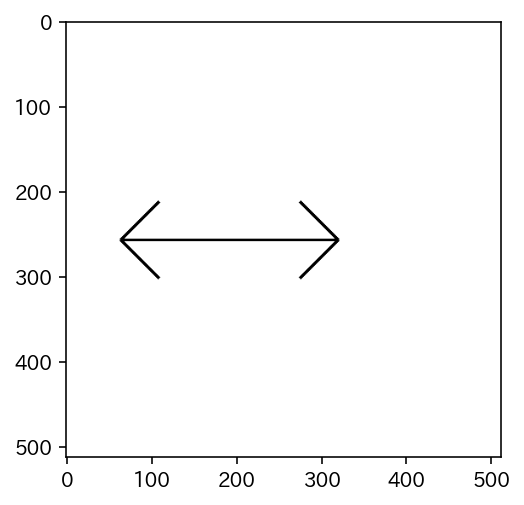

In [23]:
img, draw = make_a_canvas()
draw, bboxes = draw_dual_muller_lyers(draw=draw,) 
                                      # theta=rad, 
                                      # x_offset=128, 
                                      # x0=100, y0=256, 
                                      # fin_length=48, 
                                      # _width=9, 
                                      # _length=128, 
                                      # _len_p = 0.5,
                                      # #_width=5, _length=128, 
                                      # verbose=False)

plt.imshow(img)

bbox:[(91, 223), (325, 289)]


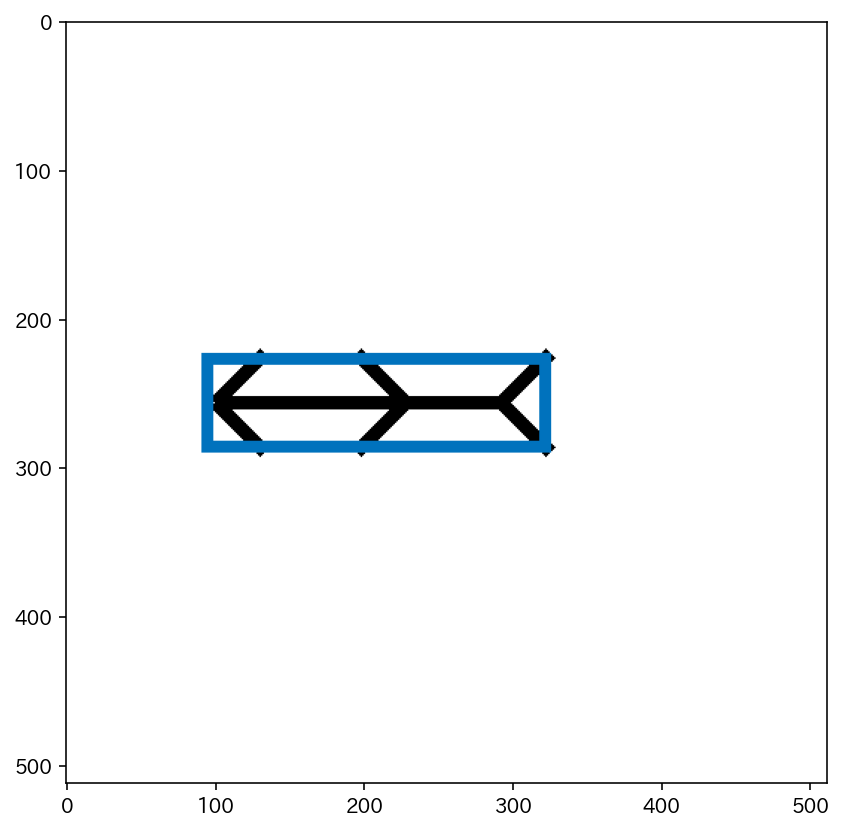

In [17]:
img, draw = make_a_canvas()
rad = np.pi / 4
draw, bboxes = draw_dual_muller_lyers(draw=draw, 
                                      theta=rad, 
                                      x_offset=128, 
                                      x0=100, y0=256, 
                                      fin_length=48, 
                                      _width=9, 
                                      _length=128, 
                                      _len_p = 0.5,
                                      #_width=5, _length=128, 
                                      verbose=False)

for bbox in bboxes:
    print(f'bbox:{bbox}')
    draw.rectangle(bbox, outline=int_COLORS[0], width=8)
    #draw.rectangle(bbox, outline=(0,255,0), width=8)

plt.figure(figsize=(7,7))
plt.imshow(img)
plt.show()

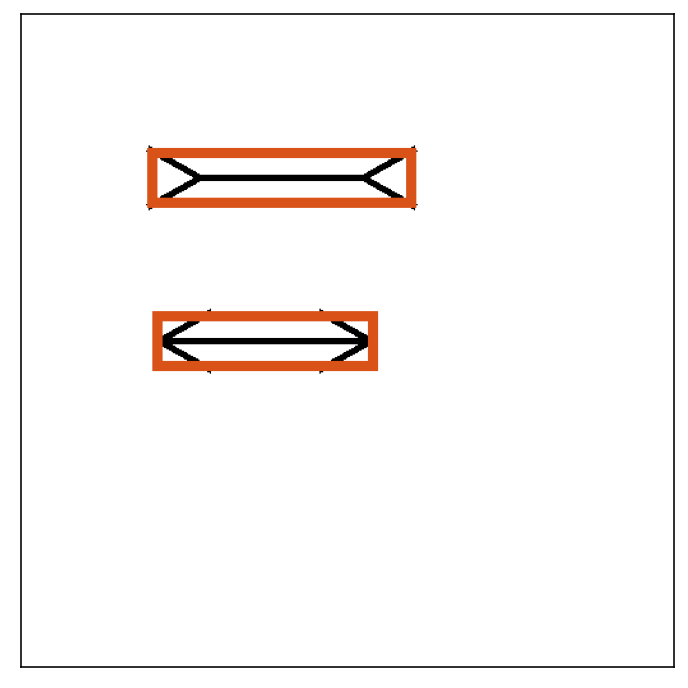

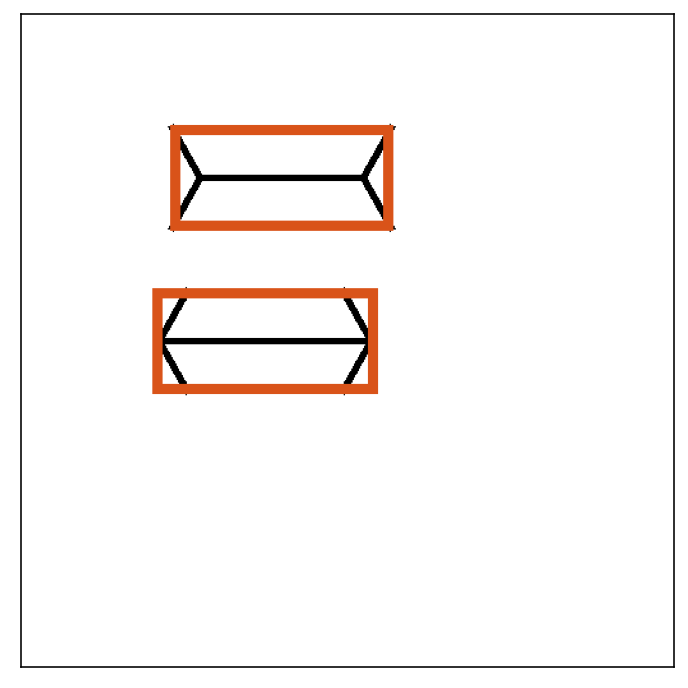

In [6]:
for deg in [150, 120]:
    plt.figure(figsize=(6,6))
    rad = deg2rad(deg)
    #print(f'deg:{deg}, rad:{rad:.3f}')
    img, draw = make_a_canvas()   
    draw, bboxes = draw_dual_muller_lyers(draw=draw, 
                                          theta=rad, 
                                          y_offset=128, 
                                          x_offset=-32,
                                          x0=140, y0=128, 
                                          fin_length=48, 
                                          _len_p = 1.3,
                                          _width=5, _length=128, 
                                          verbose=False)
    plt.xticks([]); plt.yticks([])
    for bbox in bboxes:
        draw.rectangle(bbox, outline=int_COLORS[1], width=8)
        #draw.rectangle(bbox, outline=(0,255,0), width=8)
    _ = plt.imshow(img)
    plt.show()    

bbox:[(159, 177), (369, 223)]
bbox:[(195, 277), (333, 323)]


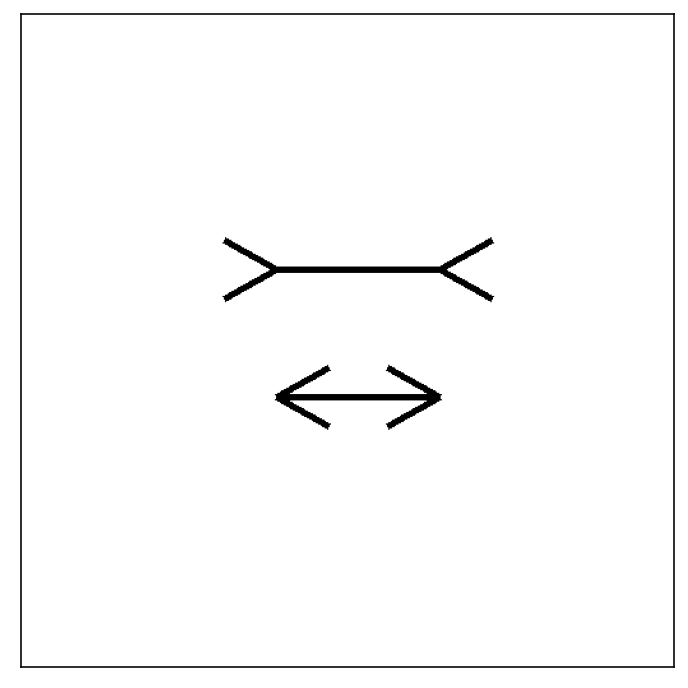

bbox:[(177, 159), (351, 241)]
bbox:[(195, 259), (333, 341)]


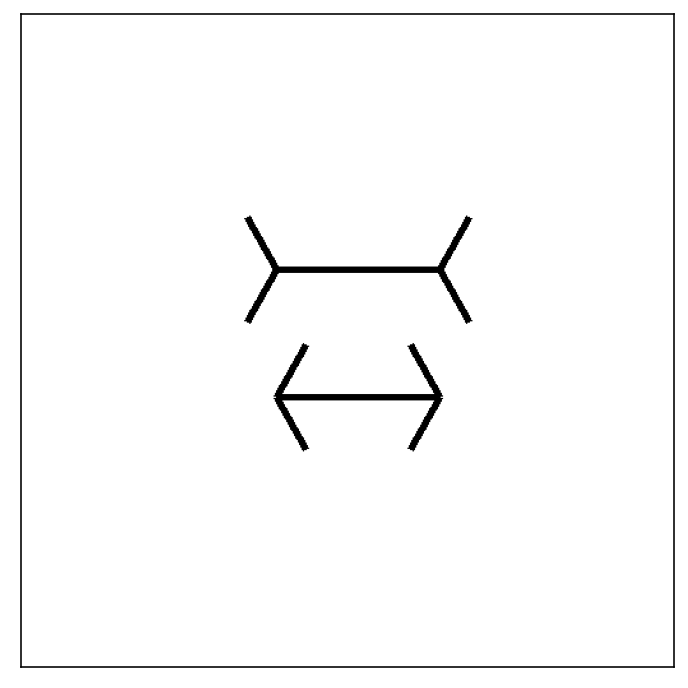

In [7]:
for deg in [150, 120]:
    plt.figure(figsize=(6,6))
    rad = deg2rad(deg)
    #print(f'deg:{deg}, rad:{rad:.3f}')
    img, draw = make_a_canvas()   
    draw, bboxes = draw_dual_muller_lyers(draw=draw, theta=rad, y_offset=100, x0=200, y0=200, fin_length=48, _width=5, _length=128, verbose=False)
    #print(f'bbox:{bbox}')
    plt.xticks([]); plt.yticks([])
    for bbox in bboxes:
        print(f'bbox:{bbox}')
        #draw.rectangle(bbox, outline=(0,255,0), width=8)
    _ = plt.imshow(img)
    plt.show()    

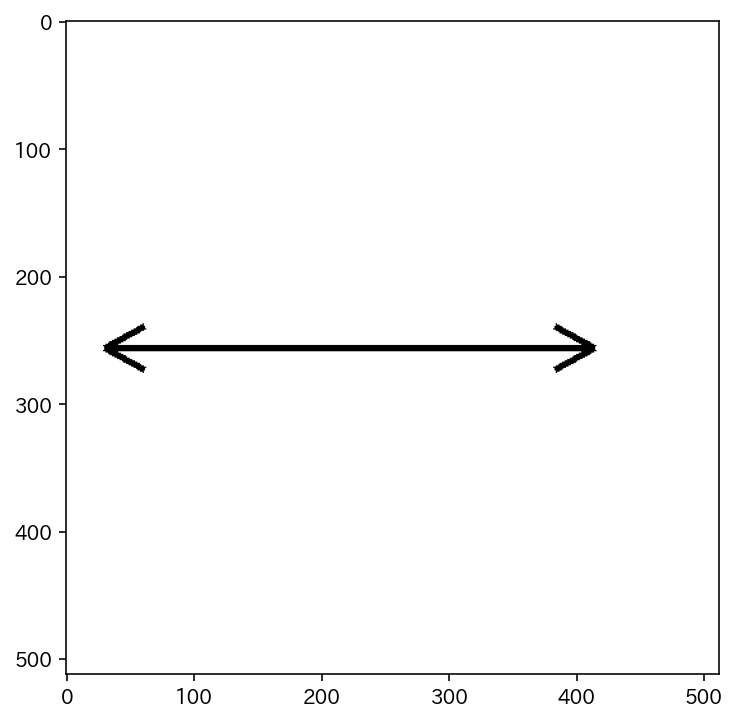

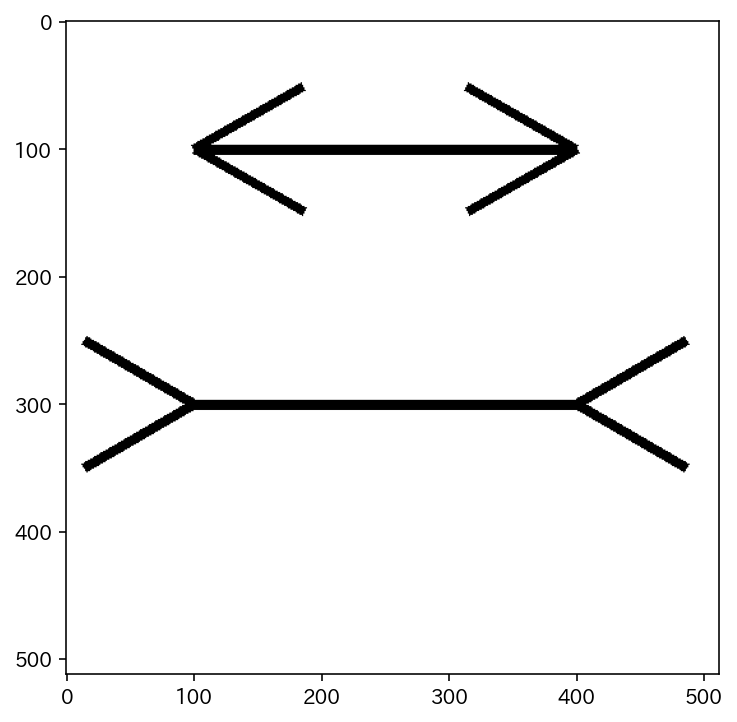

In [8]:
#img, draw = make_a_canvas(width=224,height=224)
img, draw = make_a_canvas(width=512,height=512)
draw, bbox = draw_a_muller_lyer(draw=draw, theta=(np.pi/6), fin_length=36, x0=30, y0=256, _length=384, _width=5)
plt.figure(figsize=(6,6))
plt.imshow(img)

img, draw = make_a_canvas(width=512,height=512)
draw, _ = draw_a_muller_lyer(theta=np.pi/6, draw=draw, x0=100, y0=100, _width=8, _length=300, fin_length=100)
draw, _ = draw_a_muller_lyer(draw=draw, x0=100, y0=300, _width=8, _length=300, fin_length=100, theta=np.pi/6*5)
plt.figure(figsize=(6,6))
plt.imshow(img)

15 0.2617993877991494


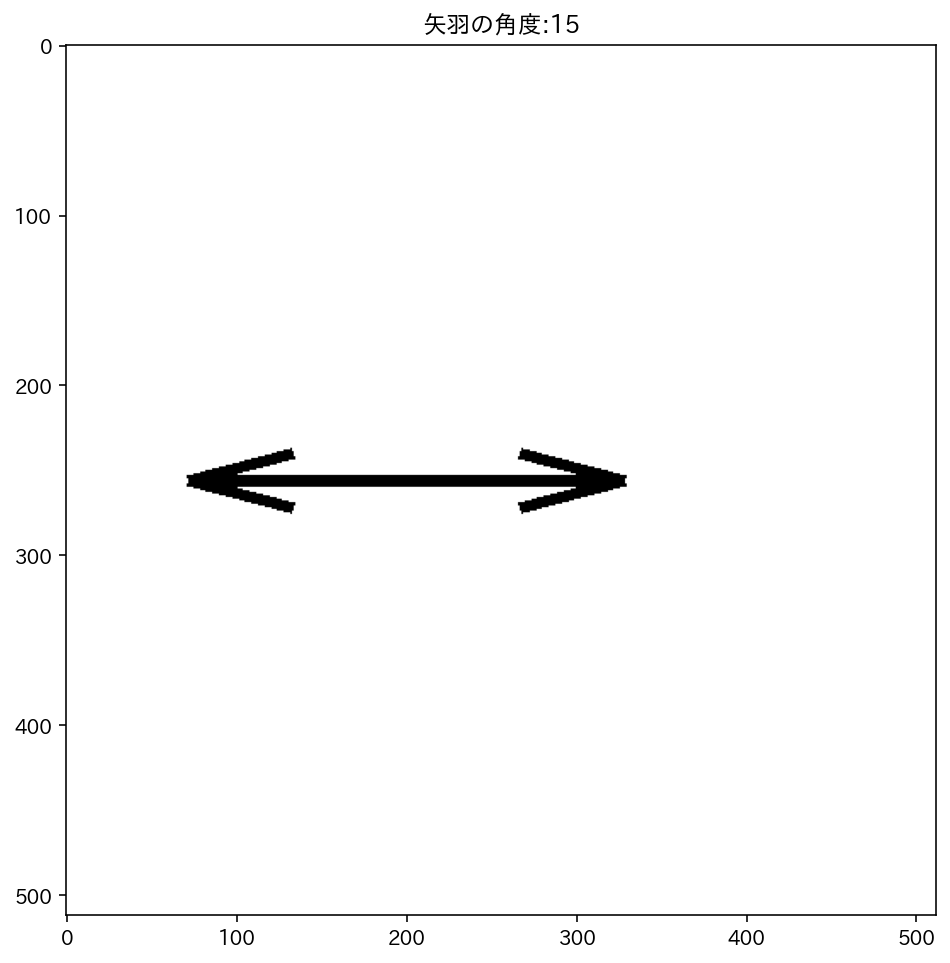

30 0.5235987755982988


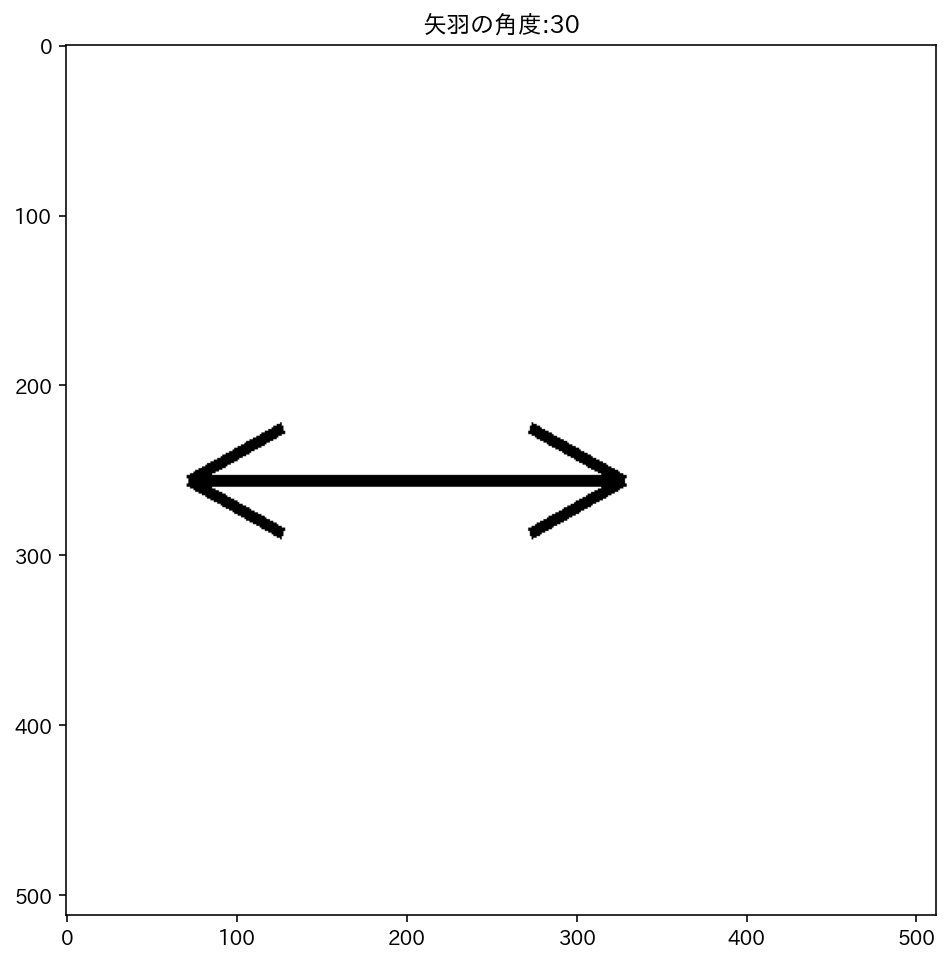

45 0.7853981633974483


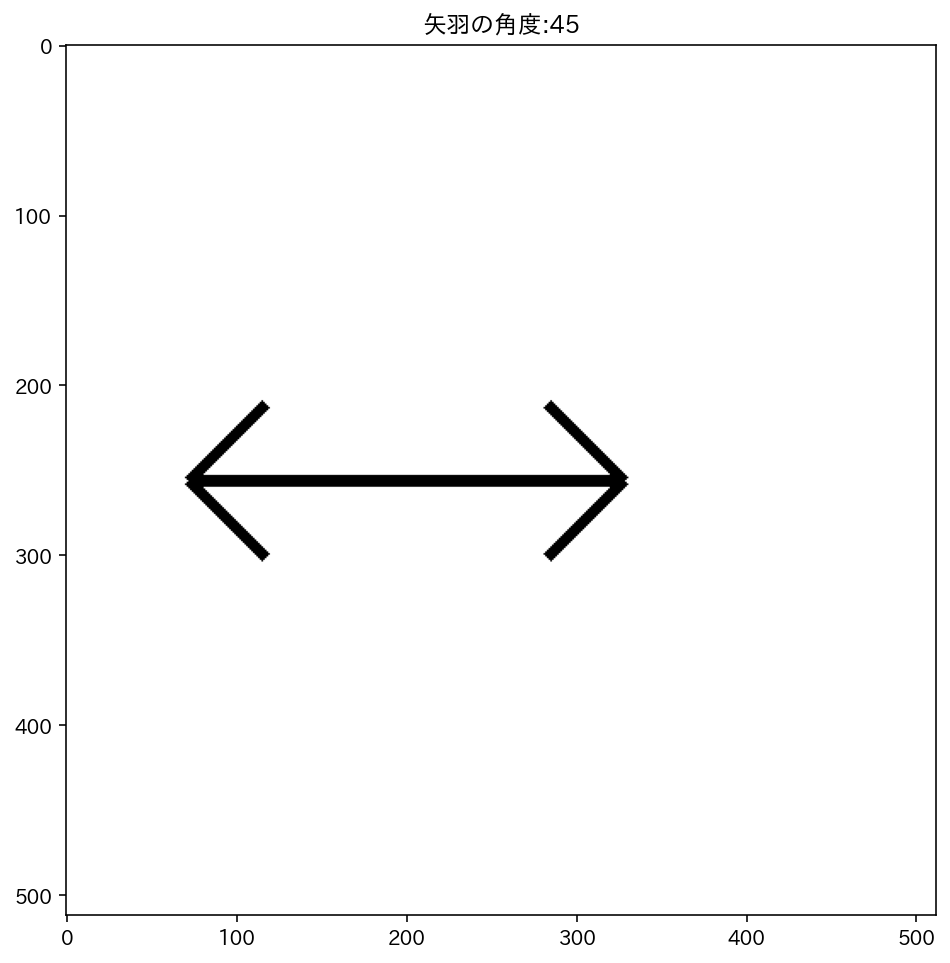

60 1.0471975511965976


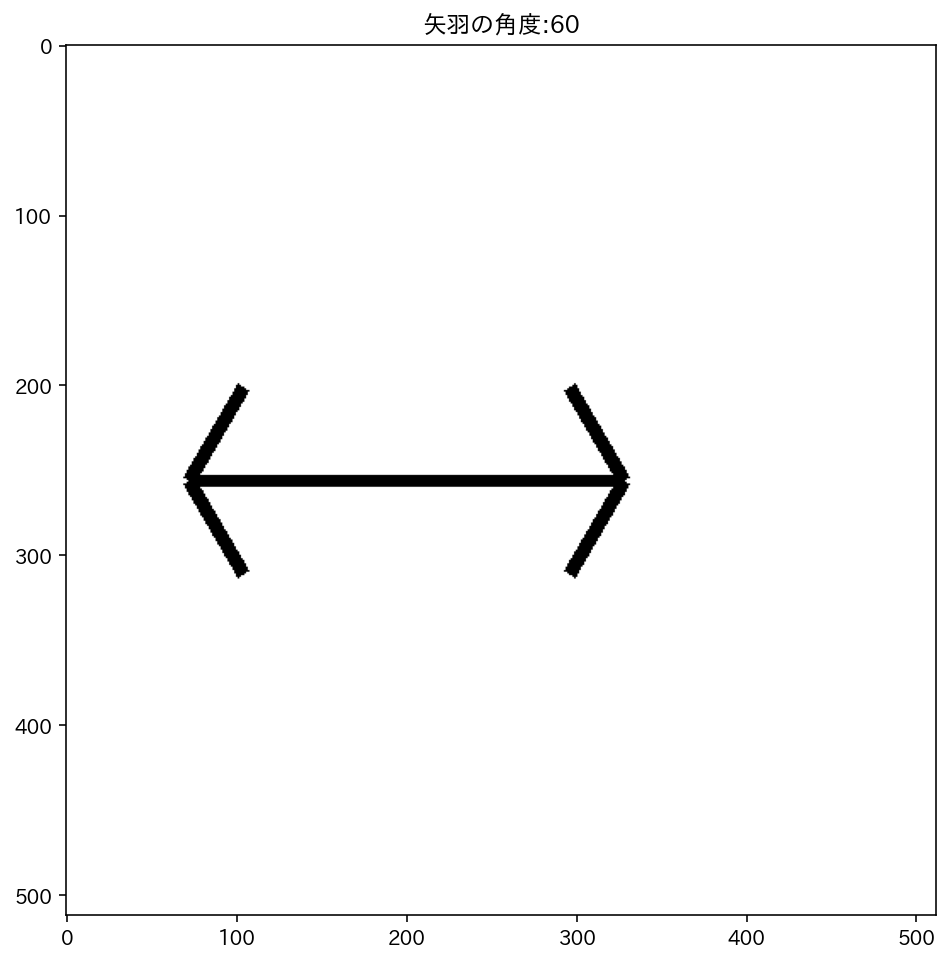

75 1.3089969389957472


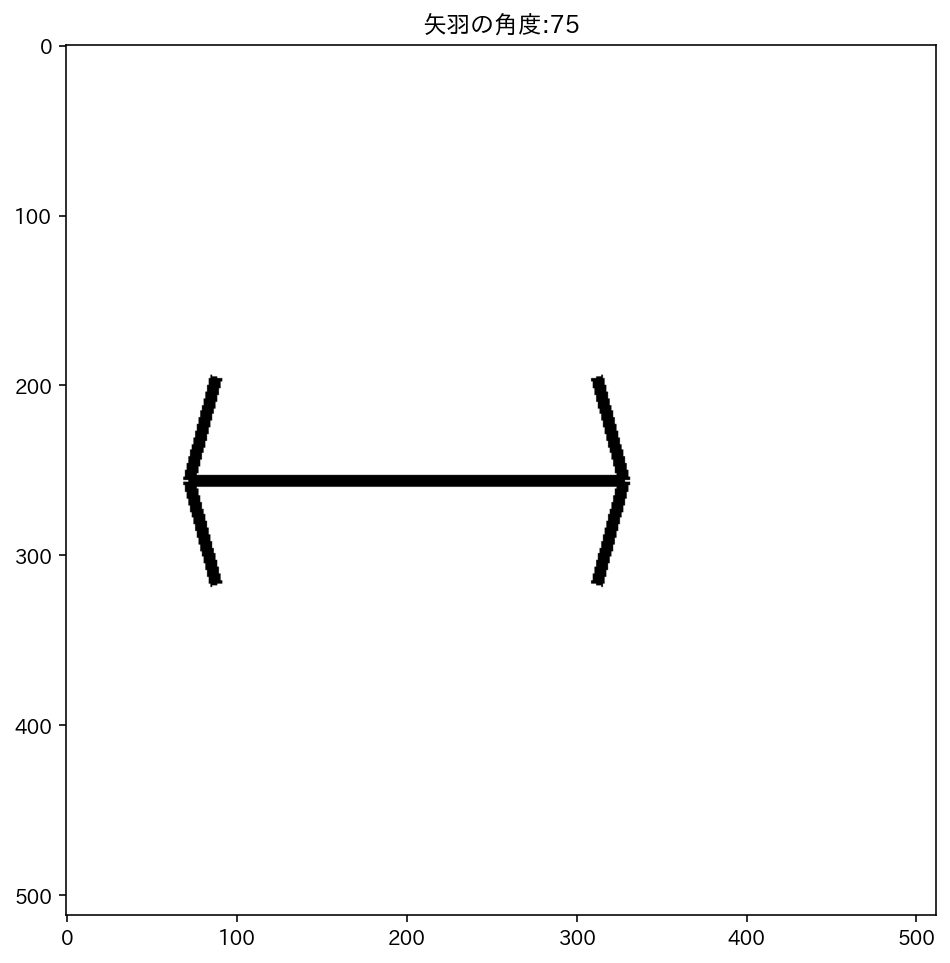

In [10]:
for deg in [15,30,45,60,75]:
    rad = deg2rad(deg)
    print(deg, rad)
    img, draw = make_a_canvas()
    plt.figure(figsize=(8,8))
    x0 = 72; y0=256
    draw = draw_a_muller_lyer(draw=draw, x0=x0, y0=y0, theta=rad, _width=7)
    plt.imshow(img)
    plt.title(f'矢羽の角度:{deg}')
    plt.show()